# Introduction
Name : Enggar Kristian\
Recruitment Process : assignments that we've provide in link https://drive.google.com/drive/folders/1hwLBIpgOxkLvmHmcD5H14c8GwbImZqvE\
Company : PT. CIMB Niaga\
Role : Data Science

OBJECTIVE: 

Data science test and your Data Science Project Portfolio details, with details as follows :

a.      Data Science Project brief can be found at the attached document [File : Loan Interest Rate].

b.      Submit the files required (Final dataset, Documentation, Presentation Slides, and Data Science Project Portfolio details)

# Import Libraries

**Note: for programming language python I used in Google Colab, so the data connect to my personal gdrive.**

In [1]:
# # Come into my google colab
# from google.colab import drive

# drive.mount('/content/gdrive')

In [2]:
# !ls

In [3]:
# # masuk folder "model_ml_dl"
# %cd /content/gdrive/MyDrive/data_science_test/CIMB - Data Science

In [4]:
# # Check folder 
# !ls

In [3]:
# importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns
from pathlib import Path
from plotly.offline import init_notebook_mode, iplot
import joblib


# cleaning text
import re # for preprocessing text
import string # for preprocessing text

# Useful functions
import joblib
import warnings
warnings.filterwarnings('ignore')

# For Handling Missing Values
from feature_engine.imputation import CategoricalImputer
from feature_engine.outliers import OutlierTrimmer
from sklearn.impute import SimpleImputer
from feature_engine.outliers import Winsorizer

# For Data Preprocessing
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTENC
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA

# Split Dataset and Standarize the Datasets
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder

# For Classification Problems
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Hyperparameter Tuning
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# Evaluate Classification Models
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import auc
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score

# Hypothesis Testing 
from scipy.stats import ttest_ind

## Useful Package

In [33]:
def check_unique(data, col_type='both'):
    """
    Count the number of unique values in each features for 'numeric', 'categorical', or 'both'

    Parameters
    ----------
    data : DataFrame

    col_type : str
        The type of the column to filter. Either 'number', 'object', or 'both'

    Returns
    -------
    DataFrame
        Number of unique values of each features
    """

    # check if the column type is valid
    if col_type not in ('number', 'object', 'both'):
        raise ValueError('col_type must be either "number", "object", or "both"')

    # create a list if the column type is 'both'
    if col_type == 'both':
        col_type = ['number', 'object']

    # get the number of unique values in each column
    data_unique_count = pd.DataFrame.from_records(
        [(col, data[col].nunique()) for col in data.select_dtypes(include=col_type).columns],
        columns=['feats', 'num_unique']
    )
    data_unique_count['pct_unique'] = data_unique_count['num_unique'] / data.shape[0] * 100

    return data_unique_count

In [34]:
def check_missing(data):
    """
    Check the missing values in dataset

    Parameters
    ----------
    data : DataFrame

    Returns
    -------
    DataFrame
        Missing values in dataset
    """

    # create a DataFrame to store the missing values
    data_missing = pd.DataFrame(data.isna().sum().sort_values(ascending=False), columns=['tot_missing']).reset_index()

    # reset the index and make the features columns
    data_missing = data_missing.rename(columns={'index': 'feats'})

    # drop the rows with no missing values
    data_missing = data_missing[data_missing['tot_missing'] > 0]

    # calculate the percentage of missing values for each features
    data_missing['tot_missing_pct'] = data_missing['tot_missing'] / len(data) * 100

    return data_missing

In [35]:
def prepare_imputation(data, variable, *args):
    """
    Prepare data for imputation

    Parameters
    ----------
    data : pandas.DataFrame
        Dataframe to be prepared for imputation
    variable : list
        List of columns to be imputed
    *args :
        List of special keywords representing the missing values

    Returns
    -------
    pandas.DataFrame
        Dataframe prepared for imputation
    """

    if data is None or variable is None:
        raise ValueError('data and variable must be specified')
    
    # prepare output dataframe
    output_data = data.copy()

    # replace missval with nan for features in impute_cols
    for col in variable:
        for missval in args:
            output_data[col] = output_data[col].replace(missval, np.nan)

    return output_data

In [36]:
def find_normal_boundaries(data, variable):
    """
    Calculate the boundaries outside which sit the outliers for a Gaussian distribution

    Parameters
    ----------
    data : DataFrame

    variable : string
        The feature of the DataFrame in which to the calculation will be performed

    Returns
    -------
    upper_boundary : float
        The computed upper boundary of the data

    lower_boundary : float
        The computed lower boundary of the data
    """

    upper_boundary = data[variable].mean() + 3 * data[variable].std()
    lower_boundary = data[variable].mean() - 3 * data[variable].std()

    return upper_boundary, lower_boundary

In [37]:
def find_skewed_boundaries(data, variable, distance):
    """
    Calculate the boundaries outside which sit the outliers for skewed distribution

    Parameters
    ----------
    data : DataFrame

    variable : string
        The feature of the DataFrame in which to the calculation will be performed

    distance : float
        The distance multiplier of IQR to calculate the boundaries

    Returns
    -------
    upper_boundary : float
        The computed upper boundary of the data

    lower_boundary : float
        The computed lower boundary of the data
    """

    IQR = data[variable].quantile(0.75) - data[variable].quantile(0.25)

    upper_boundary = data[variable].quantile(0.75) + (IQR * distance)
    lower_boundary = data[variable].quantile(0.25) - (IQR * distance)

    return upper_boundary, lower_boundary

In [38]:
def check_dist(data):
    """
    Check the Skewness and Distribution for each features in a dataset

    Parameters
    ----------
    data : DataFrame

    Returns
    -------
    DataFrame
        Skewness and distribution types of each features
    """

    # create a DataFrame containing the features of the dataset and their respective skewness
    data_skewness = pd.DataFrame(data.skew(), columns=['skew']).reset_index()

    # reset the index and make the features columns
    data_skewness = data_skewness.rename(columns={'index': 'feats'})

    # create a new column to describe whether the feature in the dataset is normal or skewed
    data_skewness['dist'] = np.where(
        (data_skewness['skew'] > -0.5) & (data_skewness['skew'] < 0.5),
        'normal',
        'skewed'
    )

    return data_skewness

In [39]:
def check_outlier(data, distance=1.5):
    """
    Check the outlier info for each features in a dataset

    Parameters
    ----------
    data : DataFrame

    distance : float
        The distance multiplier of IQR to calculate the boundaries for skewed distributions. It's either 1.5 or 3

    Returns
    -------
    DataFrame
        Outlier infos such as upper and lower boundary, and also the number of outliers for each features
    """

    if distance not in (1.5, 3):
        raise ValueError('Parameter distance only accepts numeric value of either 1.5 or 3')

    data_skewness = check_dist(data)

    # create a dictionary to store the outlier infos
    data_outlier = {
        'feats': [],
        'upper_bound': [],
        'lower_bound': [],
        'tot_right_tail': [],
        'tot_left_tail': [],
        'tot_right_tail_pct': [],
        'tot_left_tail_pct': [],
        'tot_outlier': [],
        'tot_outlier_pct': [],
    }

    # loop over each row in the `skewness` DataFrame
    # calculate each features upper and lower boundaries and the outlier percentage
    for row in data_skewness.index:
        col = data_skewness.iloc[row]['feats']

        if data_skewness.iloc[row]['dist'] == 'normal':
            upper_bound, lower_bound = find_normal_boundaries(data, col)
        else:
            upper_bound, lower_bound = find_skewed_boundaries(data, col, distance)

        tot_right_tail = len(data[data[col] > upper_bound])
        tot_left_tail = len(data[data[col] < lower_bound])
        tot_right_tail_pct = tot_right_tail / len(data) * 100
        tot_left_tail_pct = tot_left_tail / len(data) * 100
        tot_outlier =  tot_right_tail + tot_left_tail
        tot_outlier_pct = tot_right_tail_pct + tot_left_tail_pct

        data_outlier['feats'].append(col)
        data_outlier['upper_bound'].append(upper_bound)
        data_outlier['lower_bound'].append(lower_bound)
        data_outlier['tot_right_tail'].append(tot_right_tail)
        data_outlier['tot_left_tail'].append(tot_left_tail)
        data_outlier['tot_right_tail_pct'].append(tot_right_tail_pct)
        data_outlier['tot_left_tail_pct'].append(tot_left_tail_pct)
        data_outlier['tot_outlier'].append(tot_outlier)
        data_outlier['tot_outlier_pct'].append(tot_outlier_pct)
    
    data_outlier = pd.DataFrame(data_outlier)

    return data_outlier

In [40]:
def outlier_summary(data, distance=1.5):
    """
    Check the summary for outlier data, such as distribution and number of outliers for each features

    Parameters
    ----------
    data : DataFrame

    distance : float
        The distance multiplier of IQR to calculate the boundaries for skewed distributions. It's either 1.5 or 3

    Returns
    -------
    DataFrame
        Summary of outlier such as distribution and number of outliers for each features
    """

    data_skewness = check_dist(data)
    data_outlier = check_outlier(data, distance)

    outlier_summary_cols = ['feats', 'skew', 'dist', 'tot_outlier', 'tot_outlier_pct']

    data_outlier_summary = pd.merge(data_skewness, data_outlier, on=['feats'])
    data_outlier_summary = data_outlier_summary[outlier_summary_cols]

    return data_outlier_summary

In [41]:
def trim_cap_outliers(data, exception_list=[], target=None, distance=1.5):
    """
    Function to trim outliers based on the cap outliers

    Parameters
    ----------
    data : pandas DataFrame
        DataFrame to trim outliers
    exception_list : list
        List of features to be excluded from trimming
    target : pandas Series or DataFrame
        Target variable name
    distance : float
        Distance multiplier to define the cap

    Returns
    -------
    data : pandas DataFrame
        Trimmed data
    if target is not None:
        target : pandas Series or DataFrame
            Trimmed target variable
    """

    # define whether to adjust target
    adjust_target = False
    if target is not None:
        adjust_target = True

    # run outlier detection
    data_outlier = outlier_summary(data, distance)

    # create a list of columns to trim outliers for normal distribution
    norm_trim_cols = data_outlier[
        (data_outlier['dist'] == 'normal') &
        (data_outlier['tot_outlier_pct'] < 5)
    ]['feats'].to_list()

    # create a list of columns to cap outliers for normal distribution
    norm_cap_cols = data_outlier[
        (data_outlier['dist'] == 'normal') &
        (data_outlier['tot_outlier_pct'] >= 5) &
        (data_outlier['tot_outlier_pct'] < 15)
    ]['feats'].to_list()

    # create a list of columns to trim outliers for skew distribution
    skew_trim_cols = data_outlier[
        (data_outlier['dist'] == 'skewed') &
        (data_outlier['tot_outlier_pct'] < 5)
    ]['feats'].to_list()

    # create a list of columns to cap outliers for skew distribution
    skew_cap_cols = data_outlier[
        (data_outlier['dist'] == 'skewed') &
        (data_outlier['tot_outlier_pct'] >= 5) &
        (data_outlier['tot_outlier_pct'] < 15)
    ]['feats'].to_list()


    # remove exception columns from the list
    norm_trim_cols = [x for x in norm_trim_cols if x not in exception_list]
    norm_cap_cols = [x for x in norm_cap_cols if x not in exception_list]
    skew_trim_cols = [x for x in skew_trim_cols if x not in exception_list]
    skew_cap_cols = [x for x in skew_cap_cols if x not in exception_list]


    # outlier trimming for normal distribution
    if len(norm_trim_cols) > 0:
        trim_norm = OutlierTrimmer(
            capping_method='gaussian',
            tail='both',
            fold=3,
            variables=norm_trim_cols,
            missing_values='ignore'
        )

        # trim outliers for normal distribution
        data = trim_norm.fit_transform(data)

        # adjust target to match the features
        if adjust_target:
            target = target.drop(target.index.difference(data.index))


    # outlier capping for normal distribution
    if len(norm_cap_cols) > 0:
        cap_norm = Winsorizer(
            capping_method='gaussian',
            tail='both',
            fold=3,
            variables=norm_cap_cols,
            missing_values='ignore'
        )

        # cap outliers for normal distribution
        data = cap_norm.fit_transform(data)


    # outlier trimming for skewed distribution
    if len(skew_trim_cols) > 0:
        trim_skew = OutlierTrimmer(
            capping_method='iqr',
            tail='both',
            fold=1.5,
            variables=skew_trim_cols,
            missing_values='ignore'
        )

        # trim outliers for skewed distribution
        data = trim_skew.fit_transform(data)

        # adjust target to match the features
        if adjust_target:
            target = target.drop(target.index.difference(data.index))


    # outlier capping for skewed distribution
    if len(skew_cap_cols) > 0:
        cap_skew = Winsorizer(
            capping_method='iqr',
            tail='both',
            fold=1.5,
            variables=skew_cap_cols,
            missing_values='ignore'
        )

        # cap outliers for skewed distribution
        data = cap_skew.fit_transform(data)


    if adjust_target:
        return data, target
    else:
        return data

# Data Loading

In [42]:
# Load the dataset
data_train = pd.read_csv('Train.csv')
data_test = pd.read_csv('Test.csv')

In [43]:
data_train

,Loan_ID,Loan_Amount_Requested,Length_Employed,Home_Owner,Annual_Income,Income_Verified,Purpose_Of_Loan,Debt_To_Income,Inquiries_Last_6Mo,Months_Since_Deliquency,Number_Open_Accounts,Total_Accounts,Gender,Interest_Rate
0,10000001,"7,000",< 1 year,Rent,68000.0,not verified,car,18.37,0,NaN,9,14,Female,1
1,10000002,"30,000",4 years,Mortgage,NaN,VERIFIED - income,debt_consolidation,14.93,0,17.0,12,24,Female,3
2,10000003,"24,725",7 years,Mortgage,75566.4,VERIFIED - income source,debt_consolidation,15.88,0,NaN,12,16,Male,3
3,10000004,"16,000",< 1 year,NaN,56160.0,VERIFIED - income source,debt_consolidation,14.34,3,NaN,16,22,Male,3
4,10000005,"17,000",8 years,Own,96000.0,VERIFIED - income source,debt_consolidation,22.17,1,NaN,19,30,Female,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
164304,10164305,"20,725",10+ years,Rent,NaN,VERIFIED - income source,credit_card,13.56,0,NaN,13,16,Male,2
164305,10164306,"6,000",8 years,Own,NaN,VERIFIED - income source,small_business,9.12,0,36.0,13,30,Male,2
164306,10164307,"20,250",10+ years,Mortgage,NaN,VERIFIED - income,credit_card,18.17,1,NaN,17,30,Male,1
164307,10164308,"10,000",4 years,Rent,NaN,not verified,major_purchase,18.75,1,48.0,16,62,Female,3


In [44]:
data_test

,Loan_ID,Loan_Amount_Requested,Length_Employed,Home_Owner,Annual_Income,Income_Verified,Purpose_Of_Loan,Debt_To_Income,Inquiries_Last_6Mo,Months_Since_Deliquency,Number_Open_Accounts,Total_Accounts,Gender
0,10164310,"27,500",10+ years,Mortgage,129000.0,VERIFIED - income,debt_consolidation,12.87,0,68.0,10,37,Male
1,10164311,"26,000",10+ years,NaN,110000.0,not verified,credit_card,11.37,0,NaN,6,23,Male
2,10164312,"6,075",< 1 year,Rent,75000.0,VERIFIED - income,debt_consolidation,6.83,2,NaN,5,20,Male
3,10164313,"12,000",10+ years,Mortgage,73000.0,VERIFIED - income source,debt_consolidation,7.76,0,NaN,6,8,Male
4,10164314,"35,000",< 1 year,Mortgage,156000.0,not verified,debt_consolidation,9.62,0,26.0,9,21,Male
...,...,...,...,...,...,...,...,...,...,...,...,...,...
109536,10273846,"15,000",9 years,Mortgage,120000.0,VERIFIED - income,other,8.15,2,32.0,13,57,Male
109537,10273847,"9,600",10+ years,Mortgage,125000.0,not verified,credit_card,9.08,1,17.0,9,34,Male
109538,10273848,"2,000",5 years,Rent,37850.0,not verified,credit_card,11.60,0,NaN,10,11,Male
109539,10273849,"2,125",6 years,Rent,30000.0,not verified,other,24.88,0,NaN,5,6,Male


In [45]:
# Want to know data types 
print("Data Train")
print(data_train.info())
print("="*50)
print("Data Test")
print(data_test.info())

Data Train
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 164309 entries, 0 to 164308
Data columns (total 14 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Loan_ID                  164309 non-null  int64  
 1   Loan_Amount_Requested    164309 non-null  object 
 2   Length_Employed          156938 non-null  object 
 3   Home_Owner               138960 non-null  object 
 4   Annual_Income            139207 non-null  float64
 5   Income_Verified          164309 non-null  object 
 6   Purpose_Of_Loan          164309 non-null  object 
 7   Debt_To_Income           164309 non-null  float64
 8   Inquiries_Last_6Mo       164309 non-null  int64  
 9   Months_Since_Deliquency  75930 non-null   float64
 10  Number_Open_Accounts     164309 non-null  int64  
 11  Total_Accounts           164309 non-null  int64  
 12  Gender                   164309 non-null  object 
 13  Interest_Rate            164309 non-null  int64 

We have 12 column for features and 1 column `Intereset_Rate` for target. overall types we have float64(3), int64(5), and object(6). In this table have many missing values that we are should have to handle that, before we start modeling

In [46]:
# Know about unique all columns in data_trainset
for col in data_train:
    print(f'{col}: {data_train[col].unique()}')

Loan_ID: [10000001 10000002 10000003 ... 10164307 10164308 10164309]
Loan_Amount_Requested: ['7,000' '30,000' '24,725' ... '28,950' '33,325' '29,825']
Length_Employed: ['< 1 year' '4 years' '7 years' '8 years' '2 years' '10+ years' '1 year'
 nan '6 years' '9 years' '3 years' '5 years']
Home_Owner: ['Rent' 'Mortgage' nan 'Own' 'Other' 'None']
Annual_Income: [68000.      nan 75566.4 ... 51024.  28721.4 24864. ]
Income_Verified: ['not verified' 'VERIFIED - income' 'VERIFIED - income source']
Purpose_Of_Loan: ['car' 'debt_consolidation' 'credit_card' 'home_improvement'
 'major_purchase' 'other' 'medical' 'small_business' 'moving' 'wedding'
 'vacation' 'house' 'educational' 'renewable_energy']
Debt_To_Income: [18.37 14.93 15.88 ... 38.03 39.04 35.06]
Inquiries_Last_6Mo: [0 3 1 2 4 5 6 7 8]
Months_Since_Deliquency: [ nan  17.  16.  68.  13.   6.  64.  10.  63.  33.  22.  28.   8.  26.
  41.  46.  62.  21.  12.  52.   3.  65.  43.  53.  44.   1.  11.  71.
  23.  15.  48.  39.  30.  32.  18.  

In [47]:
# Want to know data describe 
print("Data Train")
print(data_train.describe().T)
print("="*50)
print("Data Test")
print(data_test.describe().T)

Data Train
                            count          mean           std         min  \
Loan_ID                  164309.0  1.008216e+07  47432.067027  10000001.0   
Annual_Income            139207.0  7.333116e+04  60377.498294      4000.0   
Debt_To_Income           164309.0  1.720719e+01      7.845083         0.0   
Inquiries_Last_6Mo       164309.0  7.816979e-01      1.034747         0.0   
Months_Since_Deliquency   75930.0  3.422936e+01     21.761180         0.0   
Number_Open_Accounts     164309.0  1.119382e+01      4.991813         0.0   
Total_Accounts           164309.0  2.506767e+01     11.583067         2.0   
Interest_Rate            164309.0  2.158951e+00      0.738364         1.0   

                                 25%          50%          75%          max  
Loan_ID                  10041078.00  10082155.00  10123232.00  10164309.00  
Annual_Income               45000.00     63000.00     88697.50   7500000.00  
Debt_To_Income                 11.37        16.84        22.7

There's  an anomali in column `Loan_Amount_Requested` it should be fload but the astype is object, and Interest_Rated should be start from 0, 1, & 2 but raw data show 1, 2, & 3

In [48]:
# Copy dataset that can use to modification dataset
data_train_copy = data_train.copy() 
data_test_copy = data_test.copy()

In [49]:
# Remove comma from that column
data_train_copy['Loan_Amount_Requested'] = data_train_copy.Loan_Amount_Requested.replace(',','', regex=True)
data_test_copy['Loan_Amount_Requested'] = data_test_copy.Loan_Amount_Requested.replace(',','', regex=True)

# Convert column asype object to float
data_train_copy['Loan_Amount_Requested'] = data_train_copy['Loan_Amount_Requested'].astype(int, errors = 'ignore')
data_test_copy['Loan_Amount_Requested'] = data_test_copy['Loan_Amount_Requested'].astype(int, errors = 'ignore')

# Change values target
data_train_copy["Interest_Rate"] = data_train_copy["Interest_Rate"].replace([1, 2, 3],[0, 1, 2])



In [50]:
data_train_copy.drop(columns='Loan_ID', axis=1, inplace=True)
data_test_copy.drop(columns='Loan_ID', axis=1, inplace=True)

In this case we will make some model machine learning, the primary key on the table like `Loan_ID` it useless for features making some model algorithms machine learning.

In [51]:
data_train_copy

,Loan_Amount_Requested,Length_Employed,Home_Owner,Annual_Income,Income_Verified,Purpose_Of_Loan,Debt_To_Income,Inquiries_Last_6Mo,Months_Since_Deliquency,Number_Open_Accounts,Total_Accounts,Gender,Interest_Rate
0,7000,< 1 year,Rent,68000.0,not verified,car,18.37,0,NaN,9,14,Female,0
1,30000,4 years,Mortgage,NaN,VERIFIED - income,debt_consolidation,14.93,0,17.0,12,24,Female,2
2,24725,7 years,Mortgage,75566.4,VERIFIED - income source,debt_consolidation,15.88,0,NaN,12,16,Male,2
3,16000,< 1 year,NaN,56160.0,VERIFIED - income source,debt_consolidation,14.34,3,NaN,16,22,Male,2
4,17000,8 years,Own,96000.0,VERIFIED - income source,debt_consolidation,22.17,1,NaN,19,30,Female,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
164304,20725,10+ years,Rent,NaN,VERIFIED - income source,credit_card,13.56,0,NaN,13,16,Male,1
164305,6000,8 years,Own,NaN,VERIFIED - income source,small_business,9.12,0,36.0,13,30,Male,1
164306,20250,10+ years,Mortgage,NaN,VERIFIED - income,credit_card,18.17,1,NaN,17,30,Male,0
164307,10000,4 years,Rent,NaN,not verified,major_purchase,18.75,1,48.0,16,62,Female,2


# Exploratory Data Analysis

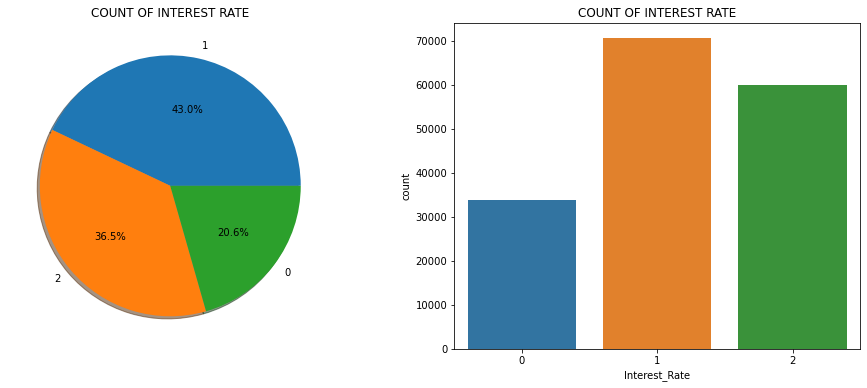

In [52]:
f,ax=plt.subplots(1,2,figsize=(16,6))
data_train_copy['Interest_Rate'].value_counts().plot.pie(autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[1].set_title('COUNT OF INTEREST RATE')
ax[0].set_title('COUNT OF INTEREST RATE')
ax[0].set_ylabel('')
sns.countplot('Interest_Rate',data=data_train_copy,ax=ax[1])
ax[1].set_title('COUNT OF INTEREST RATE')
plt.show()

Well the classification of target `Interest_Rate` have imbalance data set that we can see the graph above.

# Data Preprocessing

## Splitting Dataset

In [53]:
# Split between `X` (Features) dan `y` (target)

# Train set
X_train_loan = data_train_copy.drop('Interest_Rate', axis=1)
y_train_loan = data_train_copy['Interest_Rate']

# Test set 
X_test_loan = data_test_copy

print("Training data shape: {}".format(X_train_loan.shape))
print("Testing data shape: {}".format(X_test_loan.shape))

Training data shape: (164309, 12)
Testing data shape: (109541, 12)


The target just have in data train, so in this case there is no compare evaluation between data train and test

## Handling Missing Values

In [54]:
def check_missing(data):
    """
    Check the missing values in dataset

    Parameters
    ----------
    data : DataFrame

    Returns
    -------
    DataFrame
        Missing values in dataset
    """

    # create a DataFrame to store the missing values
    data_missing = pd.DataFrame(data.isna().sum().sort_values(ascending=False), columns=['tot_missing']).reset_index()

    # reset the index and make the features columns
    data_missing = data_missing.rename(columns={'index': 'feats'})

    # drop the rows with no missing values
    data_missing = data_missing[data_missing['tot_missing'] > 0]

    # calculate the percentage of missing values for each features
    data_missing['tot_missing_pct'] = data_missing['tot_missing'] / len(data) * 100

    return data_missing

In [55]:
# check missing values in train set
print("Missing values in data train")
check_missing(X_train_loan)

Missing values in data train


,feats,tot_missing,tot_missing_pct
0,Months_Since_Deliquency,88379,53.788289
1,Home_Owner,25349,15.427639
2,Annual_Income,25102,15.277313
3,Length_Employed,7371,4.486060


In [56]:
# check missing values in test set
print("Missing values in data test")
check_missing(X_test_loan)

Missing values in data test


,feats,tot_missing,tot_missing_pct
0,Months_Since_Deliquency,58859,53.732392
1,Annual_Income,16898,15.426187
2,Home_Owner,16711,15.255475
3,Length_Employed,4936,4.506075


Well we have same columns between data train and data test that have missing values inside. we can see above the counting of missing values each column. There are 2 columns type object `Home_Owner` and `Length_Employed` has contain missing values, and There are 2 columns type numerical `Months_Since_Deliquency` and `Annual_Income` has  contain missing values.  


In [57]:
# Drop column contain missing value >40%
X_train_loan.drop(columns='Months_Since_Deliquency', axis=1, inplace=True)
X_test_loan.drop(columns='Months_Since_Deliquency', axis=1, inplace=True)

# Fill missing values in column numerik with Median
median1 = X_train_loan["Annual_Income"].median()
median2 = X_test_loan["Annual_Income"].median()

X_train_loan["Annual_Income"] = X_train_loan["Annual_Income"].fillna(median1)
X_test_loan["Annual_Income"] = X_test_loan["Annual_Income"].fillna(median2)

# Fill missing values column categorical with most common class
X_train_loan = X_train_loan.apply(lambda x: x.fillna(x.value_counts().index[0]))
X_test_loan = X_test_loan.apply(lambda x: x.fillna(x.value_counts().index[0]))


In [58]:
X_test_loan

,Loan_Amount_Requested,Length_Employed,Home_Owner,Annual_Income,Income_Verified,Purpose_Of_Loan,Debt_To_Income,Inquiries_Last_6Mo,Number_Open_Accounts,Total_Accounts,Gender
0,27500,10+ years,Mortgage,129000.0,VERIFIED - income,debt_consolidation,12.87,0,10,37,Male
1,26000,10+ years,Mortgage,110000.0,not verified,credit_card,11.37,0,6,23,Male
2,6075,< 1 year,Rent,75000.0,VERIFIED - income,debt_consolidation,6.83,2,5,20,Male
3,12000,10+ years,Mortgage,73000.0,VERIFIED - income source,debt_consolidation,7.76,0,6,8,Male
4,35000,< 1 year,Mortgage,156000.0,not verified,debt_consolidation,9.62,0,9,21,Male
...,...,...,...,...,...,...,...,...,...,...,...
109536,15000,9 years,Mortgage,120000.0,VERIFIED - income,other,8.15,2,13,57,Male
109537,9600,10+ years,Mortgage,125000.0,not verified,credit_card,9.08,1,9,34,Male
109538,2000,5 years,Rent,37850.0,not verified,credit_card,11.60,0,10,11,Male
109539,2125,6 years,Rent,30000.0,not verified,other,24.88,0,5,6,Male


In [59]:
X_train_loan.Length_Employed.value_counts()

10+ years    60286
2 years      14620
3 years      12974
< 1 year     12805
5 years      10814
1 year       10422
4 years       9784
7 years       9308
6 years       9094
8 years       7917
9 years       6285
Name: Length_Employed, dtype: int64

In [60]:
# check missing values after fillna in train set
print("Missing values in data train")
check_missing(X_train_loan)

Missing values in data train


,feats,tot_missing,tot_missing_pct


In [61]:
# check missing values after fillna in test set
print("Missing values in data test")
check_missing(X_test_loan)

Missing values in data test


,feats,tot_missing,tot_missing_pct


There is no missin value in dataset

## Categorizing Features

Categorize the features based on the variable type of the features and the data it represents
- Numeric (Interval): Features which have equally spaced interval between unique values
- Categorical (Nominal): Features which have no intrinsic ordering to the unique values
- Ordinal: Features which have clear ordering but do not have equally spaced intervals between unique values

In [62]:
X_train_loan.head(5)

,Loan_Amount_Requested,Length_Employed,Home_Owner,Annual_Income,Income_Verified,Purpose_Of_Loan,Debt_To_Income,Inquiries_Last_6Mo,Number_Open_Accounts,Total_Accounts,Gender
0,7000,< 1 year,Rent,68000.0,not verified,car,18.37,0,9,14,Female
1,30000,4 years,Mortgage,63000.0,VERIFIED - income,debt_consolidation,14.93,0,12,24,Female
2,24725,7 years,Mortgage,75566.4,VERIFIED - income source,debt_consolidation,15.88,0,12,16,Male
3,16000,< 1 year,Mortgage,56160.0,VERIFIED - income source,debt_consolidation,14.34,3,16,22,Male
4,17000,8 years,Own,96000.0,VERIFIED - income source,debt_consolidation,22.17,1,19,30,Female


## Categorizing Features

Categorize the features based on the variable type of the features and the data it represents
- Numeric (Interval): Features which have equally spaced interval between unique values
- Categorical (Nominal): Features which have no intrinsic ordering to the unique values
- Ordinal: Features which have clear ordering but do not have equally spaced intervals between unique values

In [63]:
# Get Numerical Columns and Categorical Columns

num_cols = X_train_loan.select_dtypes(include=np.number).columns.tolist()
cat_cols = X_train_loan.select_dtypes(include=['object']).columns.tolist()

# Combines three categoy into one
final_features = num_cols + cat_cols

print('Numerical Columns : ', num_cols)
print('Categorical Columns : ', cat_cols)

Numerical Columns :  ['Loan_Amount_Requested', 'Annual_Income', 'Debt_To_Income', 'Inquiries_Last_6Mo', 'Number_Open_Accounts', 'Total_Accounts']
Categorical Columns :  ['Length_Employed', 'Home_Owner', 'Income_Verified', 'Purpose_Of_Loan', 'Gender']


## Handling Outliers

In [64]:
# check outlier summary only on numerical features
outlier_summary(X_train_loan[num_cols], 1.5)

,feats,skew,dist,tot_outlier,tot_outlier_pct
0,Loan_Amount_Requested,0.727216,skewed,0,0.000000
1,Annual_Income,43.494219,skewed,10058,6.121393
2,Debt_To_Income,0.192204,normal,0,0.000000
3,Inquiries_Last_6Mo,1.550867,skewed,12276,7.471289
4,Number_Open_Accounts,1.164084,skewed,3754,2.284720
5,Total_Accounts,0.817347,skewed,3099,1.886080


1. `Trimming`: if outliers' percentage < 5%
2. `Capping`: if outliers' percentage 5% - 15%
3. `Trimming and Capping`: if outliers' percentage > 15%

In [65]:
# check outlier details
check_outlier(X_train_loan[num_cols], 1.5)

,feats,upper_bound,lower_bound,tot_right_tail,tot_left_tail,tot_right_tail_pct,tot_left_tail_pct,tot_outlier,tot_outlier_pct
0,Loan_Amount_Requested,38000.000000,-10000.000000,0,0,0.000000,0.0,0,0.000000
1,Annual_Income,132100.000000,-1500.000000,10058,0,6.121393,0.0,10058,6.121393
2,Debt_To_Income,40.742437,-6.328059,0,0,0.000000,0.0,0,0.000000
3,Inquiries_Last_6Mo,2.500000,-1.500000,12276,0,7.471289,0.0,12276,7.471289
4,Number_Open_Accounts,23.000000,-1.000000,3754,0,2.284720,0.0,3754,2.284720
5,Total_Accounts,54.500000,-5.500000,3099,0,1.886080,0.0,3099,1.886080


Trim and cap the outliers

In [66]:
# print X_train_loan and y_train_loan shape before trimming and capping
print('X_train_loan shape before trimming and capping:', X_train_loan.shape)
print('y_train_loan shape before trimming and capping:', y_train_loan.shape)

# trim and cap outliers
X_train_loan, y_train_loan = trim_cap_outliers(
    X_train_loan,
    exception_list = cat_cols,
    distance=1.5,
    target=y_train_loan
)

# print X_train_loan and y_train_loan shape after trimming and capping
print('X_train_loan shape after trimming and capping:', X_train_loan.shape)
print('y_train_loan shape after trimming and capping:', y_train_loan.shape)

X_train_loan shape before trimming and capping: (164309, 11)
y_train_loan shape before trimming and capping: (164309,)
X_train_loan shape after trimming and capping: (158580, 11)
y_train_loan shape after trimming and capping: (158580,)


Dataset has been trim, trainset there's much trim on distribution data.

## Feature Selection

### Categorizing Selected Features

In [40]:
# display outlier summary
outlier_summary(X_train_loan[num_cols], 1.5).sort_values(by='dist')

,feats,skew,dist,tot_outlier,tot_outlier_pct
2,Debt_To_Income,0.204463,normal,0,0.000000
5,Total_Accounts,0.470101,normal,0,0.000000
0,Loan_Amount_Requested,0.739414,skewed,0,0.000000
1,Annual_Income,0.698273,skewed,0,0.000000
3,Inquiries_Last_6Mo,0.825204,skewed,0,0.000000
4,Number_Open_Accounts,0.548468,skewed,3942,2.485812


In [41]:
# check outlier details
check_outlier(X_train_loan[num_cols], 1.5)

,feats,upper_bound,lower_bound,tot_right_tail,tot_left_tail,tot_right_tail_pct,tot_left_tail_pct,tot_outlier,tot_outlier_pct
0,Loan_Amount_Requested,38000.000000,-10000.000000,0,0,0.00000,0.000000,0,0.000000
1,Annual_Income,129250.000000,-750.000000,0,0,0.00000,0.000000,0,0.000000
2,Debt_To_Income,40.559858,-6.409181,0,0,0.00000,0.000000,0,0.000000
3,Inquiries_Last_6Mo,2.500000,-1.500000,0,0,0.00000,0.000000,0,0.000000
4,Number_Open_Accounts,20.500000,0.500000,3940,2,2.48455,0.001261,3942,2.485812
5,Total_Accounts,54.985144,-6.845795,0,0,0.00000,0.000000,0,0.000000


In [42]:
# create list of numerical features with normal distribution
num_cols_norm = [
    'Loan_Amount_Requested', 'Annual_Income', 'Debt_To_Income', 'Inquiries_Last_6Mo', 'Total_Accounts'
]

# create list of numerical features with skew
num_cols_skew = [
    'Number_Open_Accounts'
]

nom_cols = [
    'Length_Employed', 'Home_Owner', 'Income_Verified', 'Purpose_Of_Loan', 'Gender'
]


Great! We have finalized our feature list.
We also separated numerical features with different types of distribution just in case we want to scale them using different methods

### List of Features

These are the predictors we're going to use

In [44]:
# print out list of predictors
print('Numerical Features:')
print(num_cols_norm + num_cols_skew)
print('=' * 100)
print('Categorical Features:')
print(nom_cols)
print('=' * 100)

Numerical Features:
['Loan_Amount_Requested', 'Annual_Income', 'Debt_To_Income', 'Inquiries_Last_6Mo', 'Total_Accounts', 'Number_Open_Accounts']
Categorical Features:
['Length_Employed', 'Home_Owner', 'Income_Verified', 'Purpose_Of_Loan', 'Gender']


## Feature Engineering

### Prepare The Necessary Objects

In [45]:
# declare standard scaler
std_sc = StandardScaler()

# declare min max scaling
mm_sc = MinMaxScaler()

# declare one hot encoder
ohe_enc = OneHotEncoder(sparse=False)


Create ColumnTransformer, SMOTENC, and PCA objects In ColumnTransformer, we will design so that our dataset will have the categorical features lined up after the numerical ones

In [46]:
# create column transformer object using min max scaler
scale_mm = ColumnTransformer([
    ('num_norm', std_sc, num_cols_norm),
    ('num_skew', mm_sc, num_cols_skew),
    ('nom', 'passthrough', nom_cols),
])

# create column transformer object for use after oversampling
encode = ColumnTransformer([
    ('num', 'passthrough', slice(0, 6)),
    ('nom', ohe_enc, slice(6, 11)),
])

# create smotenc object
# categorical features will be put at the end, after the numerical ones
smotenc = SMOTENC(
    categorical_features= list(range(5, 11)),
    random_state=42
)


### Scaling

We need to scale all numerical columns before oversampling

In [47]:
X_test_loan

,Loan_Amount_Requested,Length_Employed,Home_Owner,Annual_Income,Income_Verified,Purpose_Of_Loan,Debt_To_Income,Inquiries_Last_6Mo,Number_Open_Accounts,Total_Accounts,Gender
0,27500,10+ years,Mortgage,129000.0,VERIFIED - income,debt_consolidation,12.87,0,10,37,Male
1,26000,10+ years,Mortgage,110000.0,not verified,credit_card,11.37,0,6,23,Male
2,6075,< 1 year,Rent,75000.0,VERIFIED - income,debt_consolidation,6.83,2,5,20,Male
3,12000,10+ years,Mortgage,73000.0,VERIFIED - income source,debt_consolidation,7.76,0,6,8,Male
4,35000,< 1 year,Mortgage,156000.0,not verified,debt_consolidation,9.62,0,9,21,Male
...,...,...,...,...,...,...,...,...,...,...,...
109536,15000,9 years,Mortgage,120000.0,VERIFIED - income,other,8.15,2,13,57,Male
109537,9600,10+ years,Mortgage,125000.0,not verified,credit_card,9.08,1,9,34,Male
109538,2000,5 years,Rent,37850.0,not verified,credit_card,11.60,0,10,11,Male
109539,2125,6 years,Rent,30000.0,not verified,other,24.88,0,5,6,Male


In [48]:
# scale numeric features 
X_train_loan_scaled = scale_mm.fit_transform(X_train_loan)
X_test_loan_scaled = scale_mm.transform(X_test_loan)

# print shape
print('X_train_loan_scaled shape:', X_train_loan_scaled.shape)
print('X_test_loan_scaled shape:', X_test_loan_scaled.shape)


X_train_loan_scaled shape: (158580, 11)
X_test_loan_scaled shape: (109541, 11)


### Oversampling

Since our data is imbalance, we need to perform oversampling

In [49]:
# # oversampling using SMOTE
# X_train_loan_balanced, y_train_loan_balanced = smotenc.fit_resample(X_train_loan_scaled, y_train_loan)

# # print shape after oversampling
# print('X_train_loan_balanced shape:', X_train_loan_balanced.shape)
# print('y_train_loan_balanced shape:', y_train_loan_balanced.shape)

### Encoding

In [50]:
# encode categorical features
X_train_loan_encoded = encode.fit_transform(X_train_loan_scaled)
X_test_loan_encoded = encode.transform(X_test_loan_scaled)


# print shape
print('X_train_loan_encoded shape:', X_train_loan_encoded.shape)
print('X_test_loan_encoded shape:', X_test_loan_encoded.shape)

X_train_loan_encoded

X_train_loan_encoded shape: (158580, 41)
X_test_loan_encoded shape: (109541, 41)


array([[-0.8793086042064007, 0.02251233110220686, 0.16538544273825673,
        ..., 0.0, 1.0, 0.0],
       [1.9122534012218302, -0.15691203312509305, -0.2740543539357205,
        ..., 0.0, 1.0, 0.0],
       [1.2720147238899207, 0.2940316330000951, -0.1526974333426162, ...,
        0.0, 0.0, 1.0],
       ...,
       [-1.0006808653119759, -0.15691203312509305, -1.0162477314577574,
        ..., 0.0, 0.0, 1.0],
       [0.7288738554424715, -0.15691203312509305, 0.1398366173502349,
        ..., 0.0, 0.0, 1.0],
       [-0.6062210167188563, -0.15691203312509305, 0.30207165856417406,
        ..., 0.0, 1.0, 0.0]], dtype=object)

After encoding the fetures is so many, so i think we should reduction with pca

### Dimensionality Reduction

In [51]:
# create pca object
# declare PCA object using the whole features
pca = PCA(random_state=42)
pca.fit(X_train_loan_encoded)

# calculate cumulative sum of the explained variance ratio
cumsum = np.cumsum(pca.explained_variance_ratio_)

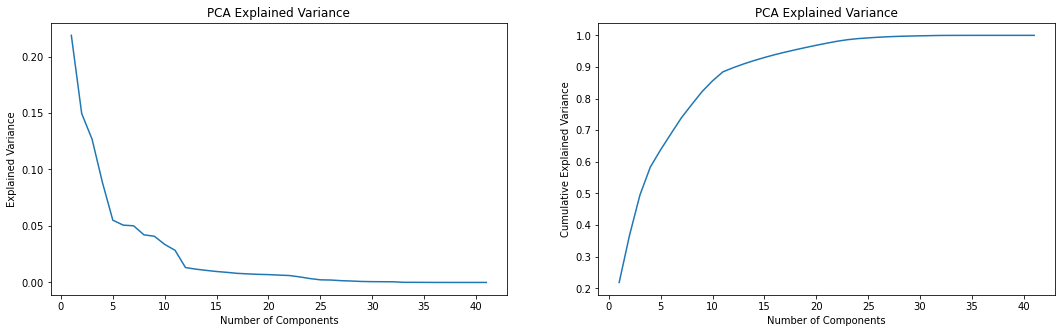

In [52]:
# plot the explained variance ratio
plt.figure(figsize=(18, 5))

# plot the explained variance ratio
plt.subplot(1, 2, 1)
plt.plot(range(1, X_train_loan_encoded.shape[1]+1), pca.explained_variance_ratio_)
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance')
plt.title('PCA Explained Variance')

# plot the cumulative sum of the explained variance ratio
plt.subplot(1, 2, 2)
plt.plot(range(1, X_train_loan_encoded.shape[1]+1), cumsum)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.show()

plt.show()

Base on graph EVR, we can take 15 features or 93% information for this model is enough.

In [53]:
# declare PCA object with the preserve ratio of 0.9
pca = PCA(n_components=0.93, random_state=42)

# perform dimensionality reduction
X_reduced = pca.fit_transform(X_train_loan_encoded)

In [54]:
# display the number of components after dimensionality reduction
pca.n_components_

15

In [55]:
# perform dimensionality reduction
X_train_loan_final = pca.fit_transform(X_train_loan_encoded)
X_test_loan_final = pca.transform(X_test_loan_encoded)

# print shape
print('X_train_loan_final shape:', X_train_loan_final.shape)
print('X_test_loan_final shape:', X_test_loan_final.shape)


X_train_loan_final shape: (158580, 15)
X_test_loan_final shape: (109541, 15)


Well the features has been reduction just have 15 features with 94% will take for modeling, it is good compression.

Let's see how it would look like in 2D

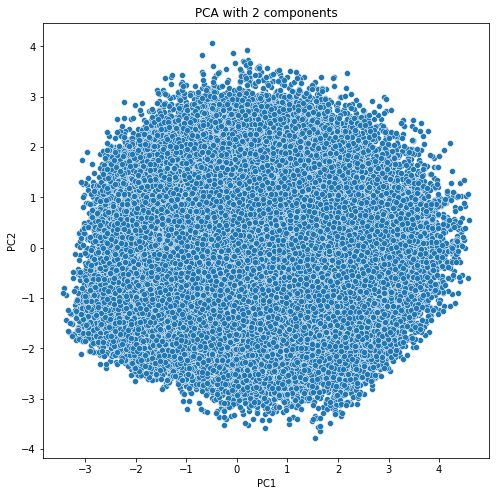

In [56]:
# plot pca with 2 components
pca_2d = PCA(n_components=2, random_state=42)
X_2d  = pca_2d.fit_transform(encode.fit_transform(X_train_loan_encoded))

plt.figure(figsize=(8, 8))
sns.scatterplot(x=X_2d[:, 0], y=X_2d[:, 1])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA with 2 components')
plt.show()

Preprocessing is finished

## Model Definition

- Target: Predicting Rating whether clients will pay to a term loan

    The target that we're going to predict is a label, which means we are going to make a classification model.
    In this case, we want to minimize the situation in which we incorrectly predicts a client won't pay (when the client is in fact will), or as in the statistical term, **False Negatives**.\
    This prediction is made so that we can target our clients and prioritize contacting those who have a high chance of subscribing. We don't want to classify a client as not potential when in fact, they should be contacted right away.

- Models: The Supervised Learning Algorithms I'm going to test
    - Logistic Regression
    - Support Vector Machine
    - Random Forest
    - XGBoost

In [57]:
# declare logreg model
logreg = LogisticRegression(random_state=42)

# declare svm model
svm = SVC(random_state=42)

# declare random forest model
rf = RandomForestClassifier(random_state=42)

# declare xgboost model
xgb = XGBClassifier(random_state=42, eval_metric='error')

## Model Training

In [58]:
# # create a dictionary of models
# models = {
#     'logreg': logreg,
#     'svm': svm,
#     'rf': rf,
#     'xgb': xgb
# }

In [59]:
# models.items()

### Cross Validating Base Models

Since the dataset is imbalance, we are going to evaluate our models based on **F1 Score**\
It's also important that we reduce the number of *False Negatives*, hence a high **Recall** is also important

In [60]:
# %time
# # create a dict to store the cross validation scores
# cv_results = {
#     'models': [],
#     'f1_score_mean': [],
#     'f1_score_std': [],
#     'recall_score_mean': [],
#     'recall_score_std': []
# } 

# # loop over each each models and perform cross validation
# for name, model in models.items():
#     # fit the model
#     model.fit(X_train_loan_final, y_train_loan)
#     # get cross validation scores
#     scores = cross_validate(
#         model, X_train_loan_final, y_train_loan,
#         scoring=['f1_weighted', 'recall'],
#         cv=3
#     )

#     # store the cross validation scores
#     cv_results['models'].append(name)
#     cv_results['f1_score_mean'].append(scores['test_f1_weighted'].mean().round(2))
#     cv_results['f1_score_std'].append(scores['test_f1_weighted'].std().round(4))
#     cv_results['recall_score_mean'].append(scores['test_recall'].mean().round(2))
#     cv_results['recall_score_std'].append(scores['test_recall'].std().round(4))

# # create a dataframe from the dict
# cv_results_df = pd.DataFrame(cv_results)

## Model Evaluation

In [61]:
# # display the dataframe sorted by f1 score
# cv_results_df.sort_values(by=['f1_score_mean', 'recall_score_mean'], ascending=False)

- Based on the cross validation score of `f1_weighted` and `recall` we can see that **Random Forest and XGBoost** are the top two
- For this research, because of time constraint and resources, we are going to finetune only one of our algorithm
- In this case, I'm going to choose **Random Forest**. However, be mindful that **SVM** should also be further delved into but SVM take a long running time time,
- Random Forest is the best model for imbalance dataset because on the model have a many parameters, and can more train more deep because the depth parameter.

### Hyperparameter Tuning Random Forest

In [62]:
# # create parameter grid for random forest
# param_grid = {
#     'criterion': ['gini', 'entropy'],
#     'max_depth': [20, 25],
#     'max_features': [1, 2, 3],
#     'min_samples_split': [2, 4],
#     'min_samples_leaf' : [4, 8],
#     'n_estimators' : [300, 400, 500]
# }

In [63]:
# # create randomized search object
# rs = GridSearchCV(
#     estimator=rf,
#     param_grid=param_grid,
#     scoring='f1_weighted',
#     cv=3, n_jobs=5, 
#     verbose=True
# )

In [64]:
# %%time

# # perform randomized search
# rs.fit(X_train_loan_final, y_train_loan)

In [65]:
# # print the best parameters
# print(f'Best parameters: {rs.best_params_}')

# # print the best score
# print(f'Best score: {rs.best_score_:.4f}')

In [66]:
# # assign the best estimator to the final model
# grid_rf = rs.best_estimator_

### Model Improvement Random Forest

In [67]:
# # Improvement with class weight each target
# rf_improve = RandomForestClassifier(bootstrap=True,            
#                              criterion='entropy',
#                              max_depth=20, max_features=3, max_leaf_nodes=8,         
#                              min_impurity_decrease=0.0, 
#                              min_samples_leaf=4, min_samples_split=2, 
#                              min_weight_fraction_leaf=0.0, n_estimators=500,
#                              oob_score=False,
#                              random_state=42,
#                              verbose=0, warm_start=False)

### Evaluate Random Forest Result

In [68]:
%%time

# perform training Random Forest
rf.fit(X_train_loan_final, y_train_loan)

CPU times: total: 2min 39s
Wall time: 3min 8s


RandomForestClassifier(random_state=42)

In [69]:
# predict train set using the improvement model
y_pred_train_loan_rf_improve = rf.predict(X_train_loan_final)

#Performance Metrics
print('==================== Train Results (Random Forest Classifier) ====================')
print(classification_report(y_train_loan, y_pred_train_loan_rf_improve))


==================== Train Results (Random Forest Classifier) ====================
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     32627
           1       1.00      1.00      1.00     68253
           2       1.00      1.00      1.00     57700

    accuracy                           1.00    158580
   macro avg       1.00      1.00      1.00    158580
weighted avg       1.00      1.00      1.00    158580



- Surprisingly algorithm Random Forest default is a better model than after gridsearch
- All metrics has result 100% it's perfect but I still suspect, need to prove, and improve


### Feature Importance Random Forest

In [70]:
data_train_copy

,Loan_Amount_Requested,Length_Employed,Home_Owner,Annual_Income,Income_Verified,Purpose_Of_Loan,Debt_To_Income,Inquiries_Last_6Mo,Months_Since_Deliquency,Number_Open_Accounts,Total_Accounts,Gender,Interest_Rate
0,7000,< 1 year,Rent,68000.0,not verified,car,18.37,0,NaN,9,14,Female,0
1,30000,4 years,Mortgage,NaN,VERIFIED - income,debt_consolidation,14.93,0,17.0,12,24,Female,2
2,24725,7 years,Mortgage,75566.4,VERIFIED - income source,debt_consolidation,15.88,0,NaN,12,16,Male,2
3,16000,< 1 year,NaN,56160.0,VERIFIED - income source,debt_consolidation,14.34,3,NaN,16,22,Male,2
4,17000,8 years,Own,96000.0,VERIFIED - income source,debt_consolidation,22.17,1,NaN,19,30,Female,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
164304,20725,10+ years,Rent,NaN,VERIFIED - income source,credit_card,13.56,0,NaN,13,16,Male,1
164305,6000,8 years,Own,NaN,VERIFIED - income source,small_business,9.12,0,36.0,13,30,Male,1
164306,20250,10+ years,Mortgage,NaN,VERIFIED - income,credit_card,18.17,1,NaN,17,30,Male,0
164307,10000,4 years,Rent,NaN,not verified,major_purchase,18.75,1,48.0,16,62,Female,2


Feature: 0, Score: 0.06540
Feature: 1, Score: 0.07043
Feature: 2, Score: 0.07561
Feature: 3, Score: 0.09600
Feature: 4, Score: 0.06430
Feature: 5, Score: 0.06029
Feature: 6, Score: 0.06074
Feature: 7, Score: 0.06643
Feature: 8, Score: 0.06471
Feature: 9, Score: 0.06344
Feature: 10, Score: 0.06112
Feature: 11, Score: 0.06352
Feature: 12, Score: 0.06860
Feature: 13, Score: 0.05961
Feature: 14, Score: 0.05979


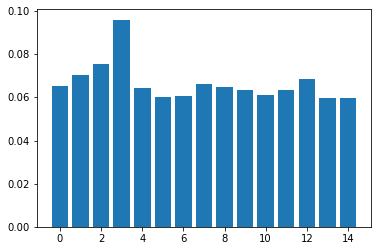

In [71]:
# get importance
importance = rf.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

- Well feature importance shows result for random forest is almost equally
- But more importance is Feature 3 = 9.6% that is column `Annual_Income`
- It's clearly why Random Forest is best algorithm for modeling to this data

### Evaluate XGBoost Classifier Result

In [72]:
%%time

# perform training XGBoost
xgb.fit(X_train_loan_final, y_train_loan)

CPU times: total: 9min 54s
Wall time: 4min 10s


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='error', gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=42, reg_alpha=0, ...)

In [73]:
# predict train set using the improvement model
y_pred_train_loan_xgb_improve = xgb.predict(X_train_loan_final)

#Performance Metrics
print('==================== Train Results (XGBoost Classifier) ====================')
print(classification_report(y_train_loan, y_pred_train_loan_xgb_improve))


==================== Train Results (XGBoost Classifier) ====================
              precision    recall  f1-score   support

           0       0.61      0.23      0.34     32627
           1       0.54      0.70      0.61     68253
           2       0.62      0.61      0.62     57700

    accuracy                           0.57    158580
   macro avg       0.59      0.52      0.52    158580
weighted avg       0.58      0.57      0.56    158580



- XGBoost algorithm shows result more bad than Random Forest
- Accuracy count 57% for XGBoost with default parameters
- Need more improve to build result more better like hyperparameter tuning and oversampling or undersampling
- We can see recall better predict label 1 is 70%, because the feature mostly support to label 1, as well as the inverse of the label 0

### Feature Importance XGBoost

Feature: 0, Score: 0.05505
Feature: 1, Score: 0.07478
Feature: 2, Score: 0.07491
Feature: 3, Score: 0.30929
Feature: 4, Score: 0.04343
Feature: 5, Score: 0.02753
Feature: 6, Score: 0.02914
Feature: 7, Score: 0.08158
Feature: 8, Score: 0.03843
Feature: 9, Score: 0.06241
Feature: 10, Score: 0.03297
Feature: 11, Score: 0.03777
Feature: 12, Score: 0.07300
Feature: 13, Score: 0.03051
Feature: 14, Score: 0.02919


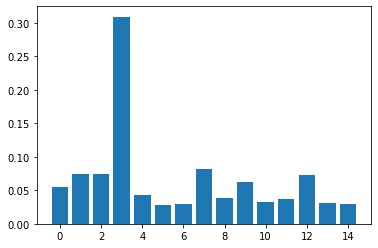

In [74]:
# get importance
importance = xgb.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

- Well feature importance shows result for XGBoost is not equal
- But more dominant importance is Feature 3 = 30.9% that is column `Annual_Income`
- It's clearly why XGBoost default parameters cannot have best result for this model

# Model Saving 

In [75]:
# create a pipeline for the final model
final_rf_pipe = Pipeline([
    ('encode', encode),
    ('pca', pca),
    ('rf', rf)
])

# create a pipeline for the final model XGBoost
final_xgb_pipe = Pipeline([
    ('encode', encode),
    ('pca', pca),
    ('xgb', xgb)
])
# fit the pipeline to the encode, scaled and model training data
final_rf_pipe.fit(X_train_loan_scaled, y_train_loan)
final_xgb_pipe.fit(X_train_loan_scaled, y_train_loan)

Pipeline(steps=[('encode',
                 ColumnTransformer(transformers=[('num', 'passthrough',
                                                  slice(0, 6, None)),
                                                 ('nom',
                                                  OneHotEncoder(sparse=False),
                                                  slice(6, 11, None))])),
                ('pca', PCA(n_components=0.93, random_state=42)),
                ('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, early_stopping_rounds=Non...
                               gamma=0, gpu_id=-1, grow_policy='depthwise',
                               importance_type=None, interaction_constraints='',
                               learning_rate=0.300000012, max_bin=256,
                               max_cat_to_onehot=4, max_delta_step=0,
                               max_depth=6, max_leaves=0, min_child_weight=1,
                               missing=nan, monotone_constraints='()',
                               n_estimators=100, n_jobs=0, num_parallel_tree=1,
                               objective='multi:softprob', predictor='auto',
                               random_state=42, reg_alpha=0, ...))])

In [76]:
final_rf_pipe

Pipeline(steps=[('encode',
                 ColumnTransformer(transformers=[('num', 'passthrough',
                                                  slice(0, 6, None)),
                                                 ('nom',
                                                  OneHotEncoder(sparse=False),
                                                  slice(6, 11, None))])),
                ('pca', PCA(n_components=0.93, random_state=42)),
                ('rf', RandomForestClassifier(random_state=42))])

In [77]:
# Save model Random Forest with joblib
with open('final_rf_pipe.pkl', 'wb') as file_1:
  joblib.dump(final_rf_pipe, file_1)

# Save model XGBoost Classifier with joblib
with open('final_xgb_pipe.pkl', 'wb') as file_2:
  joblib.dump(final_xgb_pipe, file_2)

# Save pipline scaling
with open('scale_mm.pkl', 'wb') as file_3:
  joblib.dump(scale_mm, file_3)

# Model Inference

In [4]:
# Load model Random Forest, XGBoost Classifier, and MinMax Scaler with joblib
with open('final_rf_pipe.pkl', 'rb') as file_1:
  final_rf_pipe = joblib.load(file_1)

with open('final_xgb_pipe.pkl', 'rb') as file_2:
  final_xgb_pipe = joblib.load(file_2)

with open('scale_mm.pkl', 'rb') as file_3:
  scale_mm = joblib.load(file_3)

In [5]:
final_data_train = pd.read_csv('final_data_train.csv')
final_data_train

,Loan_Amount_Requested,Length_Employed,Home_Owner,Annual_Income,Income_Verified,Purpose_Of_Loan,Debt_To_Income,Inquiries_Last_6Mo,Number_Open_Accounts,Total_Accounts,Gender,Interest_Rate
0,7000,< 1 year,Rent,68000.0,not verified,car,18.37,0.0,9,14,Female,0
1,30000,4 years,Mortgage,63000.0,VERIFIED - income,debt_consolidation,14.93,0.0,12,24,Female,2
2,24725,7 years,Mortgage,75566.4,VERIFIED - income source,debt_consolidation,15.88,0.0,12,16,Male,2
3,16000,< 1 year,Mortgage,56160.0,VERIFIED - income source,debt_consolidation,14.34,2.5,16,22,Male,2
4,17000,8 years,Own,96000.0,VERIFIED - income source,debt_consolidation,22.17,1.0,19,30,Female,0
...,...,...,...,...,...,...,...,...,...,...,...,...
158575,35000,10+ years,Rent,115000.0,VERIFIED - income,debt_consolidation,24.06,0.0,10,39,Male,2
158576,20725,10+ years,Rent,63000.0,VERIFIED - income source,credit_card,13.56,0.0,13,16,Male,1
158577,6000,8 years,Own,63000.0,VERIFIED - income source,small_business,9.12,0.0,13,30,Male,1
158578,20250,10+ years,Mortgage,63000.0,VERIFIED - income,credit_card,18.17,1.0,17,30,Male,0


In [6]:
# Load data test final
final_data_test = pd.read_csv('final_data_test.csv')
final_data_test

,Loan_Amount_Requested,Length_Employed,Home_Owner,Annual_Income,Income_Verified,Purpose_Of_Loan,Debt_To_Income,Inquiries_Last_6Mo,Number_Open_Accounts,Total_Accounts,Gender
0,27500,10+ years,Mortgage,129000.0,VERIFIED - income,debt_consolidation,12.87,0,10,37,Male
1,26000,10+ years,Mortgage,110000.0,not verified,credit_card,11.37,0,6,23,Male
2,6075,< 1 year,Rent,75000.0,VERIFIED - income,debt_consolidation,6.83,2,5,20,Male
3,12000,10+ years,Mortgage,73000.0,VERIFIED - income source,debt_consolidation,7.76,0,6,8,Male
4,35000,< 1 year,Mortgage,156000.0,not verified,debt_consolidation,9.62,0,9,21,Male
...,...,...,...,...,...,...,...,...,...,...,...
109536,15000,9 years,Mortgage,120000.0,VERIFIED - income,other,8.15,2,13,57,Male
109537,9600,10+ years,Mortgage,125000.0,not verified,credit_card,9.08,1,9,34,Male
109538,2000,5 years,Rent,37850.0,not verified,credit_card,11.60,0,10,11,Male
109539,2125,6 years,Rent,30000.0,not verified,other,24.88,0,5,6,Male


In [7]:
# Scaling data test
final_data_test_scaled = scale_mm.transform(final_data_test)
final_data_test_scaled

array([[1.608822748457892, 2.211489574675266, -0.5372072554323464, ...,
        'VERIFIED - income', 'debt_consolidation', 'Male'],
       [1.4267643567995292, 1.5296769906115262, -0.7288234458425108, ...,
        'not verified', 'credit_card', 'Male'],
       [-0.9915779457290578, 0.27370644102042674, -1.3087817821506083,
        ..., 'VERIFIED - income', 'debt_consolidation', 'Male'],
       ...,
       [-1.4861699097342769, -1.0594165851884116, -0.6994422966462854,
        ..., 'not verified', 'credit_card', 'Male'],
       [-1.4709983770960802, -1.3411128370252725, 0.99699970911837, ...,
        'not verified', 'other', 'Male'],
       [0.09166948463820136, 2.498568557438946, -1.0750100298502077, ...,
        'not verified', 'medical', 'Male']], dtype=object)

In [8]:
# predict test set using the improvement model
pred_model_rf = final_rf_pipe.predict(final_data_test_scaled)

In [9]:
# Convert into DataFrame

y_inf_pred_rf = pd.DataFrame(pred_model_rf, columns=['Interest Rate - Prediction'])
y_inf_pred_rf

,Interest Rate - Prediction
0,1
1,0
2,2
3,1
4,0
...,...
109536,2
109537,0
109538,1
109539,2


In [68]:
final_data_test['Interest_Rate'] = y_inf_pred_rf
final_data_test

,Loan_Amount_Requested,Length_Employed,Home_Owner,Annual_Income,Income_Verified,Purpose_Of_Loan,Debt_To_Income,Inquiries_Last_6Mo,Number_Open_Accounts,Total_Accounts,Gender,Interest_Rate
0,27500,10+ years,Mortgage,129000.0,VERIFIED - income,debt_consolidation,12.87,0,10,37,Male,1
1,26000,10+ years,Mortgage,110000.0,not verified,credit_card,11.37,0,6,23,Male,0
2,6075,< 1 year,Rent,75000.0,VERIFIED - income,debt_consolidation,6.83,2,5,20,Male,2
3,12000,10+ years,Mortgage,73000.0,VERIFIED - income source,debt_consolidation,7.76,0,6,8,Male,1
4,35000,< 1 year,Mortgage,156000.0,not verified,debt_consolidation,9.62,0,9,21,Male,0
...,...,...,...,...,...,...,...,...,...,...,...,...
109536,15000,9 years,Mortgage,120000.0,VERIFIED - income,other,8.15,2,13,57,Male,2
109537,9600,10+ years,Mortgage,125000.0,not verified,credit_card,9.08,1,9,34,Male,0
109538,2000,5 years,Rent,37850.0,not verified,credit_card,11.60,0,10,11,Male,1
109539,2125,6 years,Rent,30000.0,not verified,other,24.88,0,5,6,Male,2


## Final Data Set Saving

In [ ]:
# Concat data train and data test
concat_data_train = pd.concat([X_train_loan, y_train_loan], axis=1)
concat_data_train_test = pd.concat([concat_data_train, final_data_test], axis=0)

# Saving final data
Final_Data_Train = concat_data_train.to_csv('final_data_train.csv', index=False)
Final_Data_Test = final_data_test.to_csv('final_data_test.csv', index=False)
Final_Data_Train_Test = concat_data_train_test.to_csv('final_data_train_test.csv', index=False)

In [73]:
Final_Data_Train_Test = pd.read_csv('final_data_train_test.csv')
Final_Data_Train_Test

,Loan_Amount_Requested,Length_Employed,Home_Owner,Annual_Income,Income_Verified,Purpose_Of_Loan,Debt_To_Income,Inquiries_Last_6Mo,Number_Open_Accounts,Total_Accounts,Gender,Interest_Rate
0,7000,< 1 year,Rent,68000.0,not verified,car,18.37,0.0,9,14,Female,0
1,30000,4 years,Mortgage,63000.0,VERIFIED - income,debt_consolidation,14.93,0.0,12,24,Female,2
2,24725,7 years,Mortgage,75566.4,VERIFIED - income source,debt_consolidation,15.88,0.0,12,16,Male,2
3,16000,< 1 year,Mortgage,56160.0,VERIFIED - income source,debt_consolidation,14.34,2.5,16,22,Male,2
4,17000,8 years,Own,96000.0,VERIFIED - income source,debt_consolidation,22.17,1.0,19,30,Female,0
...,...,...,...,...,...,...,...,...,...,...,...,...
268116,15000,9 years,Mortgage,120000.0,VERIFIED - income,other,8.15,2.0,13,57,Male,2
268117,9600,10+ years,Mortgage,125000.0,not verified,credit_card,9.08,1.0,9,34,Male,0
268118,2000,5 years,Rent,37850.0,not verified,credit_card,11.60,0.0,10,11,Male,1
268119,2125,6 years,Rent,30000.0,not verified,other,24.88,0.0,5,6,Male,2


# Conclusion

## Understanding Data Set

- Data Test did not have column target `Interest_Rate`, so I can't compare the result between train and test result over fit or under fit or perfect
- The model just do training model in Data Train
- There are anomali data in Data Train and Data Test:
    - Column `Loan_Amount_Requested` raw data shows astype is object, but the value it should be numerik, and have some comma inside. so i decide to convert to **integer**, and replace comma.
    - Column `Interest_Rate` is an integer for targel label is 1, 2, and 3. For the model training label it should sequence so i replace to 0, 1, and 2
    - Column `Months_Since_Deliquency` astype integer have many missing values 53.78% that's bad resourch for modeling, then I drop it
- I drop column `Loan_ID` that's primary key, unfortunately that is useless for modeling
- Column Target is 0, 1, and 2 after replaced, have some imbalanced data, expetation for improvement need oversampling to have best result, but the real is no needed.

## Modeling

- As well as my own template, i do modeling sequence start with: 
    - Data Processing (Handling Missing Values, Handling Outliers, Feature Selection, Scaling, Encoding, oversampling if needed, and PCA if needed) 
    - Data Training with algorithm parameters default 
    - Cross Validation for all algorithm parameter default to looking for the best one base on precision and recall.
    - Aboslutely I got one of the best algorithm from CV and then i do improvement with hyperparameter tuning with GridSearchCV.
    - Model Evaluation with metrics Classification Report
    - Make feature importance
- I'm failed to do Cross Validation because over time until 5 hours then i dont do it again but coding still exist as my own template.
- Did hyperparameter tuning was bad result and running time was over time until 20 hours 51 minutes
- From that i decide modeling manually with choose algorithms are Random Forest and Extreme Gradient Bossting (XGBoost) with default parameters.
- Result is more better default parameter with algorithm Random Forest the classification report shows all 100%
- Feature importance also shows equally distributed each feature for algorithms Random Forest and that was very good.
- Then I decide save model Random Forest to predict Data Test for the new label base on result classification is good.

## Improvement

Random Forest have classification report shows all 100% make me suspicious, because parameter is default. Then suggested for improvement algorithm are:
- We should know best algortihm with crosss validation again
- Then we know that, we do hyperparameter tuning with many parameters inside to looking for best params
- After that training again with improvement best parameter
- We got prediction `Interest_Rate` in Data Test, we should need to re-training and re-tuning hyperparameters for Data Train and Data Test to looking for comparison result between Data Train and Data Test, it shows Over Fit or Under Fit, that's clearly modeling.